In [87]:
import pandas as pd
import fasttext
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score,precision_score,f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# open the embeddings df
mil_and_genz = pd.read_csv('data/mil_and_genz.csv')

# making sure the doc_embedding columns maintains the same format in the created and saved df
def convert_to_list(string_repr):
    # extract the numeric values from the string
    numeric_values = [float(x) for x in re.findall(r'-?\d+\.\d+', string_repr)]
    return numeric_values

# Apply the conversion function to the 'doc_embedding' column
mil_and_genz['doc_embedding'] = mil_and_genz['doc_embedding'].apply(convert_to_list)

In [3]:
# concatenate it with the vectorization df
mil_and_genz2 = pd.read_csv('data/mil_and_genz2.csv')

In [4]:
mil_and_genz_merged = pd.merge(mil_and_genz, mil_and_genz2, on=['auhtor_ID', 'post', 'birth_year', 'binary_birth_year', 'post_tokenized', 'doc_length'])
mil_and_genz_merged.to_csv('data/mil_and_genz_merged.csv')
mil_and_genz_merged

,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized,doc_embedding,doc_embedding_average,doc_length,nr_sent,avg_sentence_length,...,``,count_a,count_and,count_you,count_is,count_?,"count_""",count_/,count_#,count_!
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"['Good', 'on', 'you', 'for', 'being', 'respons...","[0.07734559, -0.14746565, 0.26790008, 0.315449...",0.017216,1550,79,18.746835,...,0.0,31,43,20,28,2,12,8,0,2
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"['must', 'go', 'to', 'the', 'grocery', 'store'...","[5.72164431, -1.28366172, 2.5229907, 3.2476326...",0.016122,1560,95,15.694737,...,0.0,24,54,31,17,8,18,5,0,3
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"['things', 'on', 'her', 'videos', ',', 'and', ...","[0.06751289, -0.11984211, 0.2425011, 0.3101618...",0.016001,1542,83,17.879518,...,0.0,33,42,41,23,3,4,7,0,0
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"['their', 'app', '.', 'There', ""'"", 's', 'also...","[0.05963879, -0.11473697, 0.23432401, 0.334987...",0.016488,1567,83,17.879518,...,0.0,36,36,31,9,0,8,7,0,4
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"['side', '.', 'If', 'the', 'cops', 'don', ""'"",...","[6.5264523, -9.7649388, 2.47386202, 3.26298296...",0.016004,1552,89,16.730337,...,0.0,47,43,34,23,2,6,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"['clever', 'political', 'meme', 'on', 'a', 'su...","[0.07314488, -0.12493327, 0.2885858, 0.3051975...",0.017437,1074,62,16.935484,...,0.0,21,23,18,18,5,0,9,0,15
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"['Kevin', '.', 'Glück', 'gehabt', '.', 'I', 'w...","[0.09270658, 0.06931888, 0.06377351, 0.3681937...",0.021317,1484,122,11.926230,...,0.0,20,29,16,9,11,40,3,0,12
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"['Handy', '/', 'der', 'Cloud', 'speichern', 'u...","[0.08413791, 0.08132758, 0.04677277, 0.3790534...",0.022058,1490,108,13.407407,...,0.0,18,19,5,4,9,22,7,0,10
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"['that', '.', ':', ')', ')', 'On', 'Google', '...","[1.19566448, 1.84456468, -6.31452948, 3.730999...",0.027131,1504,96,15.114583,...,0.0,4,3,3,1,6,30,7,0,10


In [5]:
mil_and_genz_merged.columns

Index(['auhtor_ID', 'post', 'birth_year', 'binary_birth_year',
       'post_tokenized', 'doc_embedding', 'doc_embedding_average',
       'doc_length', 'nr_sent', 'avg_sentence_length', 'pos_tags', '#', '$',
       '''', '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD',
       'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'count_a',
       'count_and', 'count_you', 'count_is', 'count_?', 'count_"', 'count_/',
       'count_#', 'count_!'],
      dtype='object')

# only doc_embedding

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.15      0.25      1946
           1       0.65      0.96      0.77      3145

    accuracy                           0.65      5091
   macro avg       0.68      0.56      0.51      5091
weighted avg       0.67      0.65      0.57      5091



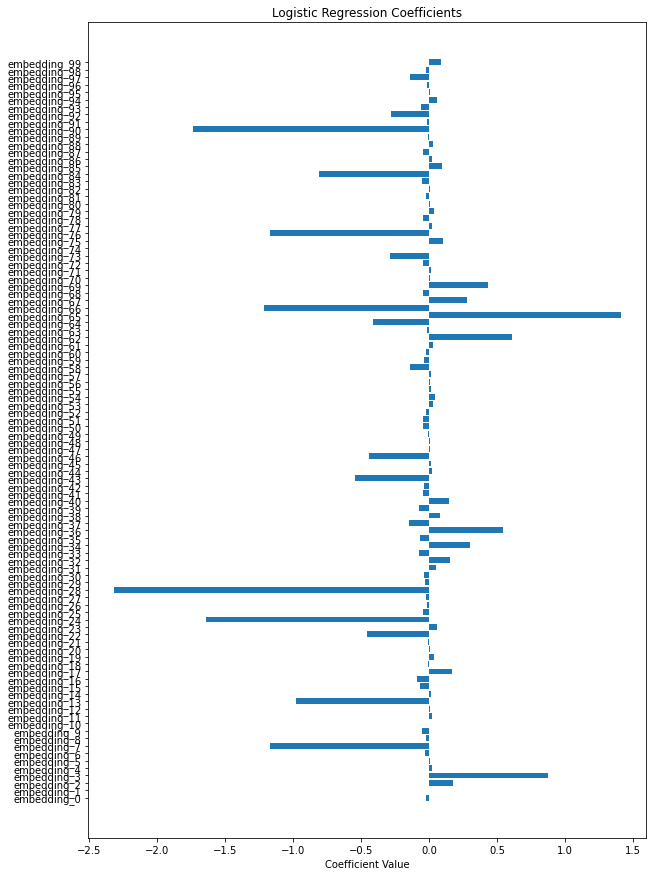

In [6]:
X_embeddings = np.vstack(mil_and_genz_merged['doc_embedding'].to_numpy())
X = np.hstack([X_embeddings])
y = mil_and_genz_merged['binary_birth_year']

# train a simple logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names = feature_names_embeddings

# Plot coefficients
plt.figure(figsize=(10, 15))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [7]:
coefficients

array([-2.43465762e-02, -1.71895396e-03,  1.72683010e-01,  8.76709882e-01,
        1.99543275e-02,  9.88351578e-03, -3.08482992e-02, -1.17161656e+00,
       -2.27137626e-02, -5.09562172e-02, -1.13594868e-03,  2.21508373e-02,
        4.82765037e-03, -9.79524585e-01,  1.40148692e-02, -6.56115676e-02,
       -8.58019919e-02,  1.68014118e-01, -8.10726934e-03,  3.47327348e-02,
        7.81051883e-03, -6.29855552e-03, -4.56320284e-01,  5.85410536e-02,
       -1.64180018e+00, -4.36847031e-02, -1.22203036e-02, -2.39768427e-02,
       -2.32097480e+00, -2.97305487e-02, -3.89069585e-02,  5.35967011e-02,
        1.52020843e-01, -7.19359200e-02,  2.98232575e-01, -6.30961357e-02,
        5.43974174e-01, -1.44449900e-01,  7.98648944e-02, -7.45482704e-02,
        1.44346698e-01, -4.34863819e-02, -3.69000333e-02, -5.48499887e-01,
        2.37373604e-02,  1.34599063e-02, -4.45863727e-01,  4.94552610e-03,
        8.94367528e-03, -1.05524537e-02, -4.41466617e-02, -4.60341706e-02,
       -2.34965925e-02,  

# doc_embedding and doc_embedding_average

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.15      0.25      1946
           1       0.65      0.96      0.77      3145

    accuracy                           0.65      5091
   macro avg       0.68      0.56      0.51      5091
weighted avg       0.68      0.65      0.57      5091



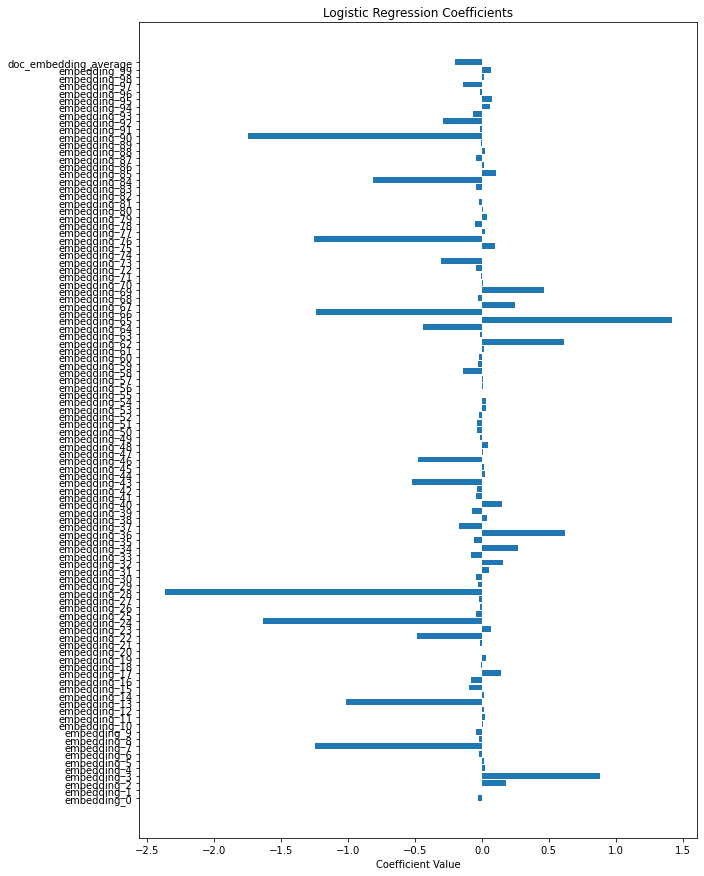

In [8]:
X_embeddings = np.vstack(mil_and_genz_merged['doc_embedding'].to_numpy())
X_doc_length = mil_and_genz_merged['doc_embedding_average'].to_numpy().reshape(-1, 1)
X = np.hstack([X_embeddings, X_doc_length])
y = mil_and_genz_merged['binary_birth_year']

# train a simple logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names = feature_names_embeddings + ['doc_embedding_average']

# Plot coefficients
plt.figure(figsize=(10, 15))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

# all coefficients except doc_embedding

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.39      0.48      1946
           1       0.70      0.86      0.77      3145

    accuracy                           0.68      5091
   macro avg       0.66      0.63      0.63      5091
weighted avg       0.67      0.68      0.66      5091



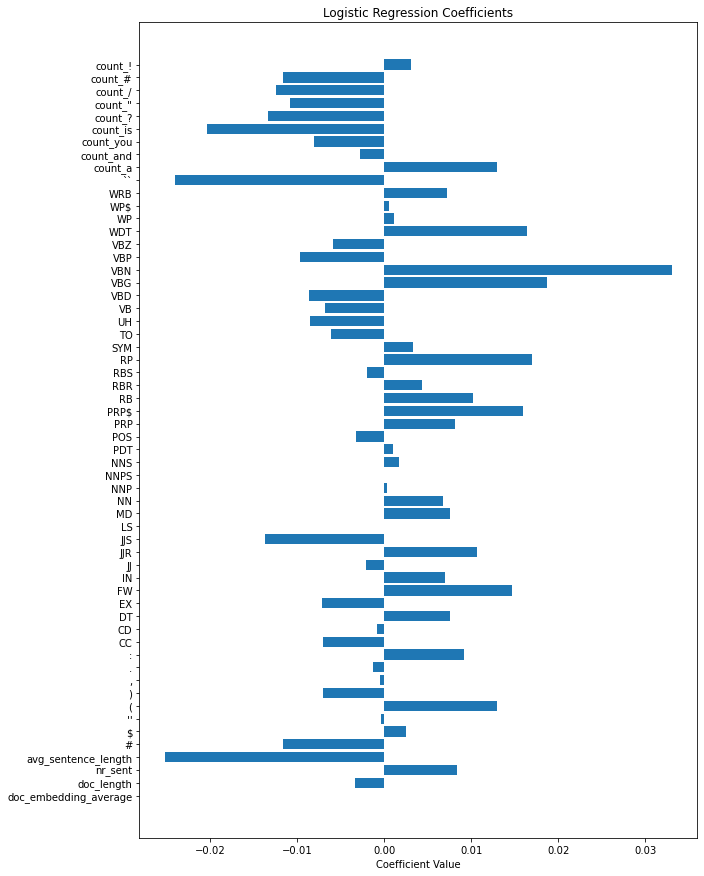

In [9]:
X_regression = mil_and_genz_merged[['doc_embedding_average', 'doc_length', 'nr_sent', 'avg_sentence_length',
       '#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', '``', 'count_a', 'count_and', 'count_you', 'count_is', 'count_?',
       'count_"', 'count_/', 'count_#', 'count_!']].to_numpy()
y_regression = mil_and_genz_merged['binary_birth_year']

# Train a logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluation for classification
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names = ['doc_embedding_average', 'doc_length', 'nr_sent', 'avg_sentence_length',
       '#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', '``', 'count_a', 'count_and', 'count_you', 'count_is', 'count_?',
       'count_"', 'count_/', 'count_#', 'count_!']

# Plot coefficients
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(coefficients)), coefficients, align='center')
plt.yticks(np.arange(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [10]:
coefficients

array([-2.74026153e-05, -3.31757227e-03,  8.31628740e-03, -2.51798795e-02,
       -1.16466540e-02,  2.56446483e-03, -3.41699350e-04,  1.29310127e-02,
       -7.06480929e-03, -4.65021743e-04, -1.30907070e-03,  9.19474505e-03,
       -7.06906574e-03, -7.67394766e-04,  7.56306648e-03, -7.15010950e-03,
        1.47390281e-02,  7.02964776e-03, -2.13220487e-03,  1.07217737e-02,
       -1.36608404e-02, -4.30310531e-05,  7.51925782e-03,  6.76429530e-03,
        3.44521294e-04,  1.03901763e-05,  1.68417763e-03,  9.84152747e-04,
       -3.25312120e-03,  8.08769777e-03,  1.58955382e-02,  1.02014490e-02,
        4.32450602e-03, -1.99826241e-03,  1.70322239e-02,  3.29149402e-03,
       -6.11228625e-03, -8.51060403e-03, -6.81253170e-03, -8.61588244e-03,
        1.87520534e-02,  3.30723723e-02, -9.60099812e-03, -5.82841140e-03,
        1.64292938e-02,  1.16369616e-03,  5.41932062e-04,  7.23313079e-03,
       -2.39818954e-02,  1.29945857e-02, -2.80207553e-03, -8.02928103e-03,
       -2.03696069e-02, -

# all coefficients

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.38      0.48      1946
           1       0.69      0.86      0.77      3145

    accuracy                           0.68      5091
   macro avg       0.66      0.62      0.62      5091
weighted avg       0.67      0.68      0.66      5091



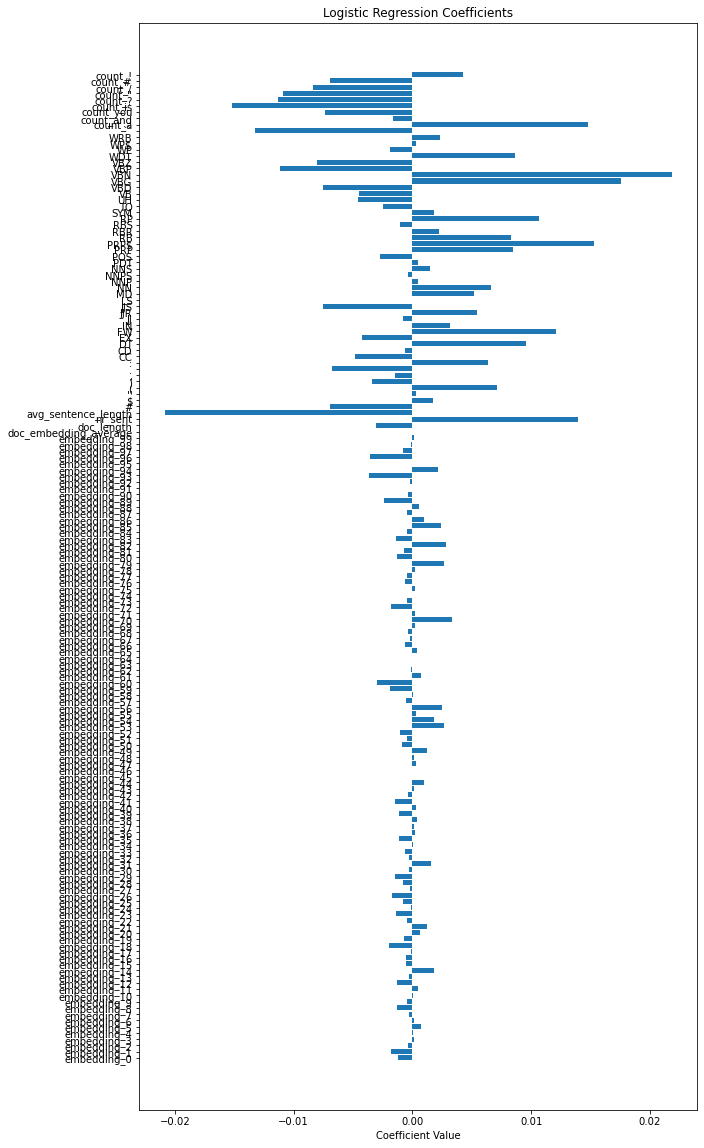

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Assuming 'doc_embedding' is a column containing lists
X_embeddings = np.vstack(mil_and_genz_merged['doc_embedding'].to_numpy())
X_doc_length = mil_and_genz_merged['doc_embedding_average'].to_numpy().reshape(-1, 1)
X_additional_features = mil_and_genz_merged[['doc_length', 'nr_sent', 'avg_sentence_length',
       '#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', '``', 'count_a', 'count_and', 'count_you', 'count_is', 'count_?',
       'count_"', 'count_/', 'count_#', 'count_!']].to_numpy()

# Concatenate embeddings and additional features
X = np.hstack([X_embeddings, X_doc_length, X_additional_features])
y = mil_and_genz_merged['binary_birth_year']

# train a logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names_additional = ['doc_embedding_average'] + [
    'doc_length', 'nr_sent', 'avg_sentence_length',
    '#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT',
    'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
    'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
    'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
    'WRB', '``', 'count_a', 'count_and', 'count_you', 'count_is', 'count_?',
    'count_"', 'count_/', 'count_#', 'count_!'
]

# Combine all feature names
feature_names = feature_names_embeddings + feature_names_additional

# Plot coefficients
plt.figure(figsize=(10, 20))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [12]:
coefficients

array([-1.19101829e-03, -1.83746588e-03, -3.58409642e-04,  1.07805299e-04,
        7.02698115e-05,  7.49521902e-04,  1.50428546e-04, -3.08179425e-04,
       -1.30935150e-03, -4.83232582e-04,  5.55915056e-05,  4.38743219e-04,
       -1.26704978e-03, -3.22220792e-04,  1.79389016e-03, -5.12772888e-04,
       -5.05586352e-04, -1.21487096e-04, -1.93881423e-03, -7.41118720e-04,
        6.20487827e-04,  1.24521717e-03, -4.09325685e-04, -1.36666920e-03,
       -9.04793665e-05, -7.84943508e-04, -1.69279222e-03, -1.75628773e-04,
       -7.71215543e-04, -1.49716918e-03, -2.73927885e-04,  1.59073041e-03,
       -3.12166296e-04, -6.08409617e-04,  8.10848946e-05, -1.10138540e-03,
        1.82813529e-04,  1.52418460e-04,  3.59837123e-04, -1.13663344e-03,
        3.31172639e-04, -1.45473123e-03, -3.53649444e-04,  1.36202753e-04,
        9.41029209e-04, -2.74569522e-05, -5.01933153e-05,  3.16955036e-04,
        1.23011403e-04,  1.25006838e-03, -8.94184722e-04, -4.76890142e-04,
       -1.04329745e-03,  

# Feature selection

In [30]:
coefficients_dict = dict(zip(feature_names, coefficients))
coefficients_dict_sorted = dict(sorted(coefficients_dict.items(), key=lambda item: abs(item[1]), reverse=True))

# 20 most important coefficients
import itertools
top_20_features = dict(itertools.islice(coefficients_dict_sorted.items(), 20))
feature_keys = list(top_20_features.keys())
feature_keys.append('binary_birth_year')
df_selected_features = mil_and_genz_merged[feature_keys]
df_selected_features

,VBN,avg_sentence_length,VBG,PRP$,count_is,count_a,nr_sent,``,FW,count_?,...,"count_""",RP,DT,WDT,PRP,count_/,RB,VBZ,JJS,binary_birth_year
0,25.0,18.746835,48.0,41.0,28,31,79,0.0,0.0,2,...,12,13.0,146.0,6.0,133.0,8,84.0,56.0,4.0,0
1,16.0,15.694737,45.0,51.0,17,24,95,0.0,2.0,8,...,18,17.0,129.0,5.0,135.0,5,73.0,38.0,1.0,0
2,20.0,17.879518,47.0,55.0,23,33,83,0.0,0.0,3,...,4,8.0,117.0,3.0,163.0,7,89.0,41.0,6.0,0
3,21.0,17.879518,40.0,44.0,9,36,83,0.0,4.0,0,...,8,9.0,129.0,4.0,184.0,7,95.0,41.0,3.0,0
4,19.0,16.730337,36.0,40.0,23,47,89,0.0,2.0,2,...,6,11.0,125.0,9.0,149.0,5,92.0,47.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25450,13.0,16.935484,30.0,27.0,18,21,62,0.0,0.0,5,...,0,7.0,100.0,3.0,64.0,9,49.0,30.0,4.0,1
25451,16.0,11.926230,15.0,23.0,9,20,122,0.0,0.0,11,...,40,0.0,53.0,0.0,74.0,3,76.0,26.0,3.0,1
25452,7.0,13.407407,9.0,14.0,4,18,108,0.0,4.0,9,...,22,8.0,68.0,1.0,73.0,7,65.0,24.0,2.0,1
25453,5.0,15.114583,2.0,7.0,1,4,96,0.0,19.0,6,...,30,0.0,14.0,0.0,14.0,7,43.0,32.0,1.0,1


# logreg with feature selected

### baseline model

In [70]:
# only use top 20 most important features
X = df_selected_features.drop(['binary_birth_year'],axis=1)
y = df_selected_features['binary_birth_year']

# majority baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6117221873035826
Precision Score : 0.6117221873035826
Recall Score : 1.0
F1 Score : 0.7590913522472457
Confusion Matrix : 
[[   0 2471]
 [   0 3893]]


### with default parameters

In [71]:
clf = LogisticRegression().fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6623192960402263
Precision Score : 0.6684698608964451
Recall Score : 0.8887747238633444
F1 Score : 0.7630389238063734
Confusion Matrix : 
[[ 755 1716]
 [ 433 3460]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### with gridsearch

In [72]:
clf = LogisticRegression(solver='liblinear')
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)
print('Gridsearch results:\n C: ' + str(grid_clf_acc.best_estimator_.get_params()['C']) + ' penalty: ' + str(grid_clf_acc.best_estimator_.get_params()['penalty']))

# New Model Evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Gridsearch results:
 C: 0.09 penalty: l2
Accuracy Score : 0.6616907605279698
Precision Score : 0.6659671880961465
Recall Score : 0.8967377343950681
F1 Score : 0.7643130815544609


array([[ 720, 1751],
       [ 402, 3491]], dtype=int64)

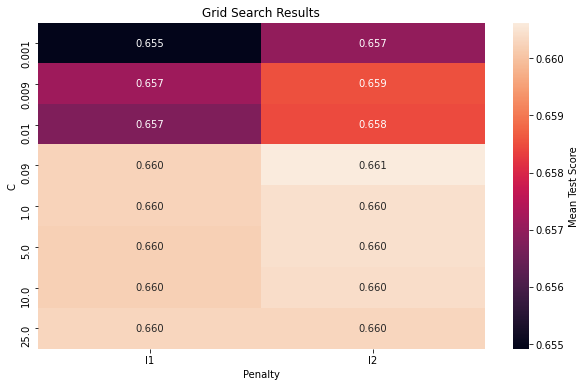

In [76]:
results = pd.DataFrame(grid_clf_acc.cv_results_)
heatmap_data = results.pivot(index='param_C', columns='param_penalty', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results')
plt.xlabel('Penalty')
plt.ylabel('C')
plt.show()

## logreg with all features Baseline model

In [64]:
# only use top 20 most important features
#X = df_selected_features.drop(['binary_birth_year'],axis=1)
#y = df_selected_features['binary_birth_year']

X_embeddings = np.vstack(mil_and_genz_merged['doc_embedding'].to_numpy())
X_doc_length = mil_and_genz_merged['doc_embedding_average'].to_numpy().reshape(-1, 1)
X_additional_features = mil_and_genz_merged[['doc_length', 'nr_sent', 'avg_sentence_length',
       '#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', '``', 'count_a', 'count_and', 'count_you', 'count_is', 'count_?',
       'count_"', 'count_/', 'count_#', 'count_!']].to_numpy()

# Concatenate embeddings and additional features
X = np.hstack([X_embeddings, X_doc_length, X_additional_features])
y = mil_and_genz_merged['binary_birth_year']

# majority baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6117221873035826
Precision Score : 0.6117221873035826
Recall Score : 1.0
F1 Score : 0.7590913522472457
Confusion Matrix : 
[[   0 2471]
 [   0 3893]]


### with default parameters

In [65]:
clf = LogisticRegression().fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6862036455059711
Precision Score : 0.692839707078926
Recall Score : 0.8749036732596969
F1 Score : 0.7733000340560789
Confusion Matrix : 
[[ 961 1510]
 [ 487 3406]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### gridsearch

In [66]:
clf = LogisticRegression(solver='liblinear')
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)
print('Gridsearch results:\n C: ' + str(grid_clf_acc.best_estimator_.get_params()['C']) + ' penalty: ' + str(grid_clf_acc.best_estimator_.get_params()['penalty']))

# New Model Evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Gridsearch results:
 C: 25 penalty: l2
Accuracy Score : 0.6948460087994972
Precision Score : 0.6992035940371656
Recall Score : 0.8795273567942461
F1 Score : 0.7790671217292379


array([[ 998, 1473],
       [ 469, 3424]], dtype=int64)

# Naive bayes

In [80]:
# alpha fit_prior class_prior
clf = GaussianNB()
grid_values = {'var_smoothing':[0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001,0.001,0.01]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)
print('Gridsearch results:\n var_smoothing: ' + str(grid_clf_acc.best_estimator_.get_params()['var_smoothing']))

# New Model Evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Gridsearch results:
 var_smoothing: 0.001
Accuracy Score : 0.64487743557511
Precision Score : 0.6409946468658263
Recall Score : 0.9535062933470332
F1 Score : 0.7666253614209004


array([[ 392, 2079],
       [ 181, 3712]], dtype=int64)

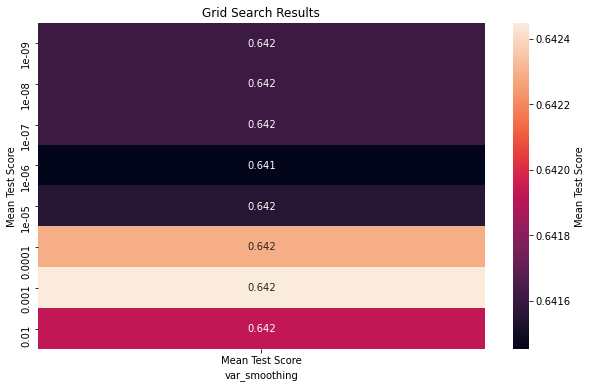

In [86]:
results = grid_clf_acc.cv_results_
param_values = results['param_var_smoothing'].data
mean_test_scores = results['mean_test_score']

# Create a DataFrame for seaborn
heatmap_data = pd.DataFrame({'var_smoothing': param_values, 'Mean Test Score': mean_test_scores})

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.set_index('var_smoothing'), annot=True, fmt='.3f', cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results')
plt.xlabel('var_smoothing')
plt.ylabel('Mean Test Score')
plt.show()

# SVM

In [92]:
clf = SVC()
grid_values = {'C':[0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf', 'sigmoid']}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)
print('Gridsearch results:\n C: ' + str(grid_clf_acc.best_estimator_.get_params()['C']) + ' gamma: ' + str(grid_clf_acc.best_estimator_.get_params()['gamma']) + ' kernel: ' + str(grid_clf_acc.best_estimator_.get_params()['kernel']))

# New Model Evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Gridsearch results:
 C: 1 gamma: 0.001 kernel: rbf
Accuracy Score : 0.7521998742928976
Precision Score : 0.7525076319232447
Recall Score : 0.8864628820960698
F1 Score : 0.8140110862129968


array([[1336, 1135],
       [ 442, 3451]], dtype=int64)

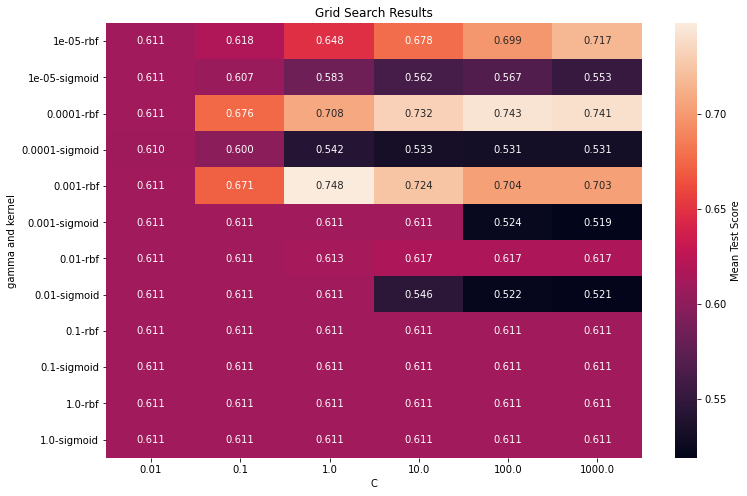

In [93]:
results = grid_clf_acc.cv_results_
param_C_values = results['param_C'].data
param_gamma_values = results['param_gamma'].data
param_kernel_values = results['param_kernel'].data
mean_test_scores = results['mean_test_score']
heatmap_data = pd.DataFrame({'C': param_C_values, 'gamma': param_gamma_values, 'kernel': param_kernel_values, 'Mean Test Score': mean_test_scores})

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.pivot_table(index=['gamma', 'kernel'], columns='C', values='Mean Test Score'),
            annot=True, fmt='.3f', cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results')
plt.xlabel('C')
plt.ylabel('gamma and kernel')
plt.show()